## III. A SIMPLE MODEL <br />

<div style="text-align:justify;text-indent:15px;"> As we have seen in the previous chapter, the guitar string exhibits harmonic modes of vibration. The movement of the string depends on several parameters, in particular the plucking point and the initial displacement from equilibrium. Typically, a guitarist presses the string on the fretboard at a given position, which reduces the "effective" string length. This results in a higher-pitched note, i.e a sound whose fundamental frequency is higher. We present here a simple model to simulate guitar sounds, solely based on the string motion (ignoring the effect of the guitar body). The goal is to verify and visualize a number of assumptions made earlier. Note that for the moment, we assume ideally flexible strings and we do not take into account the inharmonicity effect. We will explore the latter in detail in Chapter V. </div>

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.mlab as pltlab

import sounddevice as sd

from string_model import *

### III.I Global parameters <br />

<div style="text-align:justify;"> In order to simulate realistic guitar sounds, the various parameters are taken from a real set of acoustic guitar strings (Martin M170PK3, 80/20 Bronze, Extra Light gauges). Additionally, we will assume a standard tuning from here on until the end of the project (from top to bottom: E2, A2, D3, G3, B3 and E4 in standard pitch notation). Note that in this chapter, we denote the low-E string (E2) as the first string, in contrast to the usual numbering 6 through 1. </div>

In [2]:
# =================
# String parameters
# ==================
# standard tuning
fundamental_freqs = np.array([82.4, 110.0, 146.8, 196.0, 246.9, 329.6])

# real set of strings
string_diameters = (1/39.17) * np.array([47, 39, 30, 23, 14, 10]) * 1e-3
string_length = .64

# linear densities (approximate numbers taken from Wikipedia)
p_steel = 7850
p_bronze = 8600
p_strings = p_bronze * (string_diameters/2)**2 * np.pi
p_strings[4:] = p_steel * (string_diameters[4:]/2)**2 * np.pi

# applied tensions and wave speeds
tensions = 4*(string_length**2)*(fundamental_freqs**2)*p_strings
velocities = np.sqrt(tensions/p_strings)

# ====================
# "Playing" parameters
# =====================
original_pluck = 1/5 + (np.random.rand() - 0.5)/30
init_displacement = 3e-3
max_mode = 10
modes_num = np.arange(1, max_mode + 1)

# ==================================
# Simulation & algorithms parameters
# ===================================
f_samp = 44100
T_samp = 1/f_samp
simulation_duration = 5.0
t = np.arange(0.0, simulation_duration, T_samp)
NFFT = 4096
noverlap = NFFT/2

### III.II Computing the string motion <br />

<div style="text-align:justify;"> The final string motion is made up of a number of characteristic modes of vibration. As we saw, these depend on several parameters (string length, tension, material, etc). Once these are fixed, it merely depends on the fundamental frequency, the initial displacement, and the plucking point. Fletcher and Rossing ([2]) have computed an expression for the amplitude of the vibrational modes of a string of length $L$, plucked with amplitude $h$ at a point $x = L/\beta$ (a fraction $\beta$ of its length), </div><br />

\begin{equation}
        B_n = \frac{\beta^2h}{2n^2\pi^2} \sin \Big(\frac{n\pi}{\beta}\Big)
\end{equation}

<br /><div style="text-align:justify;"> In our simulations, the synthesized sounds correspond solely to the string motion. Therefore, the different harmonics and their relative strengths are precisely related to the above equation. If $N$ is the maximum mode number we consider, the string motion is obtained as </div><br />

\begin{equation}
        y(x, t) = \sum_{n=1}^{N} B_n \ \sin(2 \pi n f_0 t) \ \sin(k_n x) \ e^{-\alpha_nt}
\end{equation}

<br /><div style="text-align:justify;"> where $f_0$ is the fundamental frequency of the string we consider. The exponential decay term mimics the damping effect, which is frequency-dependent. </div>


##### A simple example

To demonstrate our model, we first look at an example.

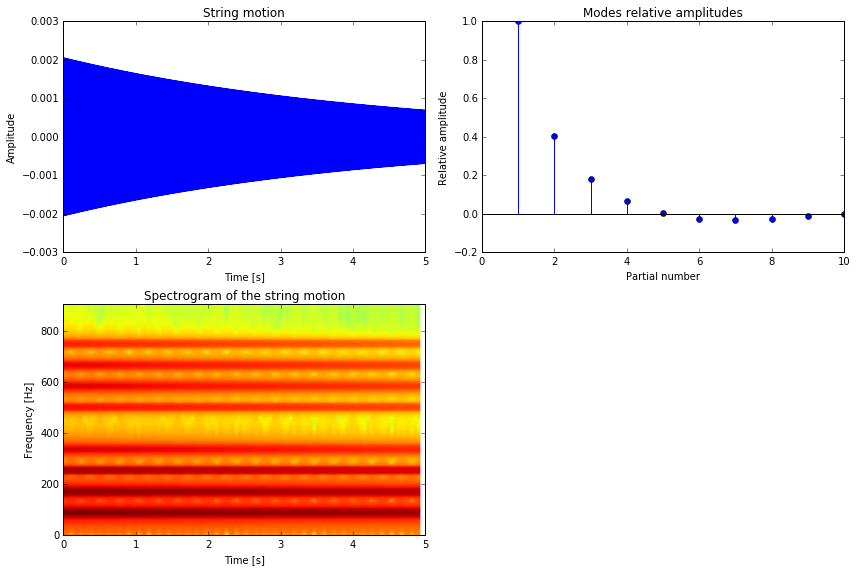

In [3]:
# example parameters (E2)
string_num = 1
f0 = fundamental_freqs[string_num - 1]
c = velocities[string_num - 1]
ref_point = string_length/5

# compute the modes' amplitudes and the string motion
modes_amplitudes, string_motion = create_string_motion(modes_num, max_mode, init_displacement, original_pluck, \
                                                       ref_point, f0, c, t)

# plot the results
plot_string_motion(f0, string_motion, modes_amplitudes, t, max_mode, modes_num, NFFT, f_samp, noverlap)

# OPTIONAL: play the synthesized sound
#sd.play(500 * string_motion, f_samp)

<br /><div style="text-align:justify;"> The string motion corresponds to a superposition of damped sinusoidal oscillations, as we expect from the previous equation and all we have seen in the introductory chapter. As can be seen on the upper right plot, the modes' amplitudes show a sinc-like behaviour, with a (nearly) zero amplitude for all the modes number that are multiples of 5. This behaviour can also be observed clearly from the spectrogram in the lower part of the above plot. </div>


##### An interactive "virtual guitar" <br />
<div style="text-align:justify;"> To play around with our simple model, we now set up an interactive "virtual guitar". The reader/user can change the string number and fretboard position, and visualize the corresponding string motion, relative modes' amplitudes and spectrogram. Note that we assume that the plucking point along the string remains the same. </div>

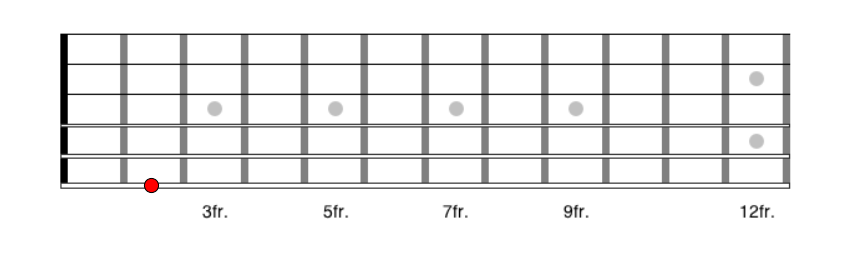

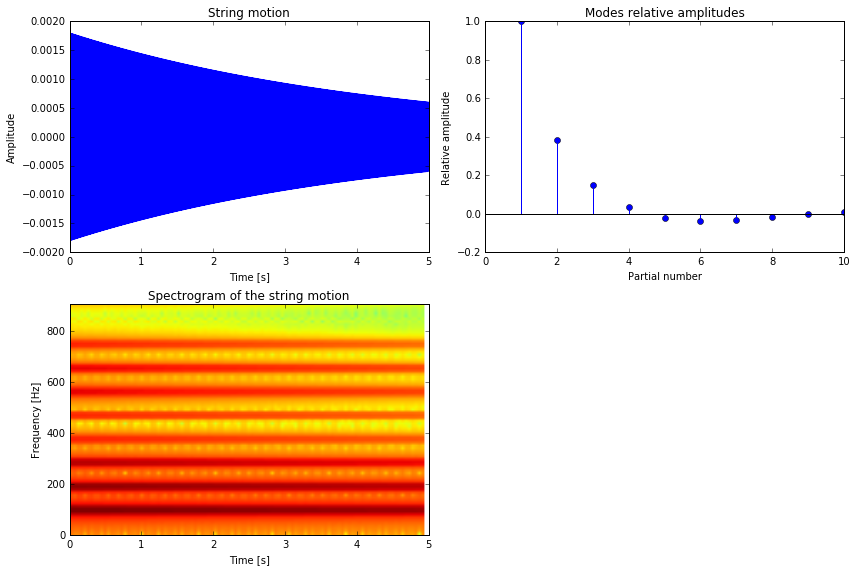

In [4]:
from ipywidgets import *

def interactive_string(string_num, fret_pos):
    
    # global variables to enable interactive plots
    global string_motion
    global modes_amplitudes
    global string_length
    global ref_point
    
    # initializations
    current_length = string_length
    c = velocities[string_num - 1]
    
    # compute the effective string length for the given position
    current_length = compute_string_length(string_length, fret_pos)
    
    # compute the new plucking point (relative to the new length)
    plucking_point = original_pluck * string_length / current_length
    
    # compute the modes' amplitudes and string motion
    modes_amplitudes, string_motion = create_string_motion(modes_num, max_mode, init_displacement, \
                                         plucking_point, ref_point, c/(2*current_length), c, t)
    
    # draw the virtual fingerboard and current fingering
    show_freboard((string_num, fret_pos))
    
    # plot the result
    plot_string_motion(f0, string_motion, modes_amplitudes, t, max_mode, modes_num, NFFT, f_samp, noverlap)
    
    # OPTIONAL: play the synthesized sound
    #sd.play(500 * string_motion, f_samp)
    
    return

# initializations
string_motion = []
modes_amplitudes = []

# interactive plot
interact(interactive_string, string_num=(1, 6, 1), fret_pos=(0, 12, 1))

### III.III Comparing different fingerings <br />

<div style="text-align:justify;"> Now that we have a working model for the string motion, we can compare two different fingerings of the same note. A fingering can be simply indexed by a pair $(n_i, p_i)$, where $n_i$ is the string number (between 1 and 6) and $p_i$ is the position on the fingerboard (between 0 and 12 for simplicity). </div>

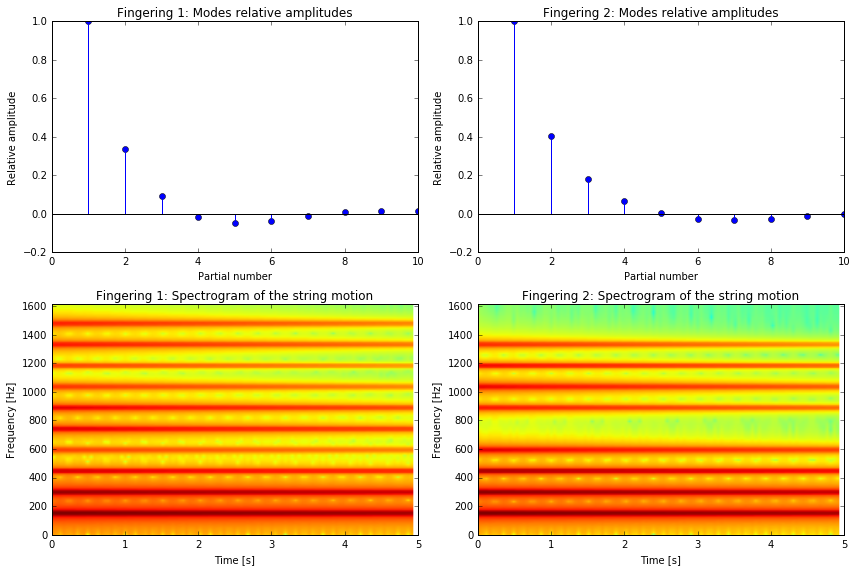

In [5]:
# two fingerings of the note A2
fingering_1 = (1, 5)
fingering_2 = (2, 0)

# compare the two fingerings
compare_fingerings(fingering_1, fingering_2, string_length, original_pluck, init_displacement, \
                   string_length/5, velocities, t, modes_num, max_mode, NFFT, f_samp, noverlap)

<div style="text-align:justify;"> As we can see, the two different fingerings of the note A2 show different characteristics. The modes' amplitudes are slightly different, as can be seen on the upper part of the above plot. It is perhaps more clear by looking at the lower part of the plot, and compare the two spectrograms. Indeed, assuming that the string is plucked at the same position (1/5 of its length), the two vibration recipes will differ. Therefore, even with a very simple model, we can capture some of the differences between different fingerings of the same note. </div>